# Predict Bike Sharing Demand with AutoGluon Template

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.

2. Scroll down to API and click Create New API Token.

3. Open up `kaggle.json` and use the username and key.


## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 958 kB 5.2 MB/s            
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 47.3 MB 1.6 MB/s            
     |████████████████████████████████| 8.6 MB 45.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080040 sha256=9449ad18e7b7f21458f09f67e27418f35fa33b0798286204f4084b5aac10653e
  Stored in directory: /root/.cache/pip/wheels/9f/9e/ac/f24f30e119df73511fde9af8aa747217ac8824e662037ba9a8
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you ha

### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "****"
kaggle_key = "****"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms


In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 52.4MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 44.9MB/s]
  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 42.2MB/s]
unzip:  cannot find or open bike-sharing-demand.zip, bike-sharing-demand.zip.zip or bike-sharing-demand.zip.ZIP.


In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('/content/train.csv')
train.head()

datetime  season  holiday  ...  casual  registered  count
0  2011-01-01 00:00:00       1        0  ...       3          13     16
1  2011-01-01 01:00:00       1        0  ...       8          32     40
2  2011-01-01 02:00:00       1        0  ...       5          27     32
3  2011-01-01 03:00:00       1        0  ...       3          10     13
4  2011-01-01 04:00:00       1        0  ...       0           1      1

[5 rows x 12 columns]

In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.

In [7]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('/content/test.csv')
test.head()

datetime  season  holiday  ...   atemp  humidity  windspeed
0  2011-01-20 00:00:00       1        0  ...  11.365        56    26.0027
1  2011-01-20 01:00:00       1        0  ...  13.635        56     0.0000
2  2011-01-20 02:00:00       1        0  ...  13.635        56     0.0000
3  2011-01-20 03:00:00       1        0  ...  12.880        56    11.0014
4  2011-01-20 04:00:00       1        0  ...  12.880        56    11.0014

[5 rows x 9 columns]

In [8]:
# Same thing as train and test dataset
submission = pd.read_csv('/content/sampleSubmission.csv')
submission.head()

datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:

predictor = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse"
    ).fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,
    presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220112_200321/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220112_200321/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12652.29 MB
	Train Data (Original)  Memory Usage: 1.52 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Genera

[1000]	train_set's rmse: 123.806	valid_set's rmse: 134.369
[2000]	train_set's rmse: 117.412	valid_set's rmse: 133.705


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 123.42	valid_set's rmse: 141.5


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 125.097	valid_set's rmse: 128.797
[2000]	train_set's rmse: 119.003	valid_set's rmse: 127.909
[3000]	train_set's rmse: 114.63	valid_set's rmse: 127.431
[4000]	train_set's rmse: 111.295	valid_set's rmse: 126.943
[5000]	train_set's rmse: 108.576	valid_set's rmse: 126.844
[6000]	train_set's rmse: 106.085	valid_set's rmse: 126.71


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.131	valid_set's rmse: 138.303
[2000]	train_set's rmse: 117.833	valid_set's rmse: 137.535


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.871	valid_set's rmse: 128.052
[2000]	train_set's rmse: 118.547	valid_set's rmse: 127.003
[3000]	train_set's rmse: 114.124	valid_set's rmse: 126.834
[4000]	train_set's rmse: 110.645	valid_set's rmse: 126.694


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.654	valid_set's rmse: 135.095
[2000]	train_set's rmse: 118.764	valid_set's rmse: 133.849
[3000]	train_set's rmse: 114.615	valid_set's rmse: 133.509
[4000]	train_set's rmse: 111.249	valid_set's rmse: 133.472
[5000]	train_set's rmse: 108.455	valid_set's rmse: 133.281


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.01	valid_set's rmse: 139.355
[2000]	train_set's rmse: 117.819	valid_set's rmse: 138.312
[3000]	train_set's rmse: 113.4	valid_set's rmse: 137.886
[4000]	train_set's rmse: 110.032	valid_set's rmse: 137.758


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.47	valid_set's rmse: 135.412


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.18	valid_set's rmse: 137.579
[2000]	train_set's rmse: 117.782	valid_set's rmse: 136.664
[3000]	train_set's rmse: 113.447	valid_set's rmse: 136.246
[4000]	train_set's rmse: 109.982	valid_set's rmse: 136.227


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.641	valid_set's rmse: 132.484


	-134.0883	 = Validation score   (root_mean_squared_error)
	49.65s	 = Training   runtime
	2.28s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 341.59s of the 541.61s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' arg

[1000]	train_set's rmse: 96.0217	valid_set's rmse: 123.249


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 94.7479	valid_set's rmse: 135.635


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.3055	valid_set's rmse: 132.087


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.1635	valid_set's rmse: 131.521


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-132.2864	 = Validation score   (root_mean_squared_error)
	13.14s	 = Training   runtime
	0.52s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 326.37s of the 526.39s of remaining time.
	-118.4567	 = Validation score   (root_mean_squared_error)
	7.78s	 = Training   runtime

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -114.633955       7.914121  537.970252                0.000742           0.442141            3       True         20
1   NeuralNetFastAI_BAG_L2 -115.260912       6.837862  475.174306                0.401848          92.892406            2       True         18
2        LightGBMXT_BAG_L2 -115.691557       6.802000  395.838906                0.365986          13.557006            2       True         13
3          CatBoost_BAG_L2 -116.264149       6.478003  414.976249                0.041988          32.694349            2       True         16
4          LightGBM_BAG_L2 -116.787704       6.530967  390.618613                0.094953           8.336713            2       True         14
5     ExtraTreesMSE_BAG_L2 -117.530917       7.008604  390.047636         

{'leaderboard':                      model   score_val  ...  can_infer  fit_order
 0      WeightedEnsemble_L3 -114.633955  ...       True         20
 1   NeuralNetFastAI_BAG_L2 -115.260912  ...       True         18
 2        LightGBMXT_BAG_L2 -115.691557  ...       True         13
 3          CatBoost_BAG_L2 -116.264149  ...       True         16
 4          LightGBM_BAG_L2 -116.787704  ...       True         14
 5     ExtraTreesMSE_BAG_L2 -117.530917  ...       True         17
 6      WeightedEnsemble_L2 -118.441149  ...       True         12
 7   RandomForestMSE_BAG_L1 -118.456660  ...       True          5
 8           XGBoost_BAG_L2 -118.916190  ...       True         19
 9   RandomForestMSE_BAG_L2 -118.999586  ...       True         15
 10    ExtraTreesMSE_BAG_L1 -128.733445  ...       True          7
 11         LightGBM_BAG_L1 -132.286410  ...       True          4
 12          XGBoost_BAG_L1 -132.308522  ...       True          9
 13         CatBoost_BAG_L1 -132.349692  ...   

### Create predictions from test dataset

In [ ]:
predictions = predictor.predict(test)
predictions = {'datetime': test['datetime'], 'Pred_count': predictions}
predictions = pd.DataFrame(data=predictions)
predictions.head()

datetime  Pred_count
0  2011-01-20 00:00:00   97.191711
1  2011-01-20 01:00:00   96.002457
2  2011-01-20 02:00:00   96.004128
3  2011-01-20 03:00:00  108.303314
4  2011-01-20 04:00:00  108.164223

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

Pred_count
count  6493.000000
mean    211.974594
std     128.192108
min     -17.967422
25%     108.682953
50%     194.932404
75%     297.041199
max     665.298035

In [ ]:
# How many negative values do we have?
neg = predictions.groupby(predictions['Pred_count'])

# lambda function
def minus(val):
   return val[val < 0].sum()

print(neg['Pred_count'].agg([('negcount', minus)]))

               negTemp
Pred_count            
-17.967422  -17.967422
-16.763763  -16.763763
-11.901270  -11.901270
 2.954704     0.000000
 7.204733     0.000000
...                ...
 649.348022   0.000000
 653.048584   0.000000
 654.244263   0.000000
 657.741089   0.000000
 665.298035   0.000000

[6490 rows x 1 columns]


In [ ]:
# Set them to zero
predictions[predictions['Pred_count']<0] = 0

In [ ]:
predictions.describe()

Pred_count
count  6493.000000
mean    211.981750
std     128.179794
min       0.000000
25%     108.682953
50%     194.932404
75%     297.041199
max     665.298035

In [ ]:
predictions.head()

datetime  Pred_count
0  2011-01-20 00:00:00   97.191711
1  2011-01-20 01:00:00   96.002457
2  2011-01-20 02:00:00   96.004128
3  2011-01-20 03:00:00  108.303314
4  2011-01-20 04:00:00  108.164223

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions['Pred_count']
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:04<00:00, 45.7kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-01-12 20:46:44  first raw submission  complete  1.39920      1.39920       


#### Initial score of 1.39920

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efbe2944890>,
      dtype=object)

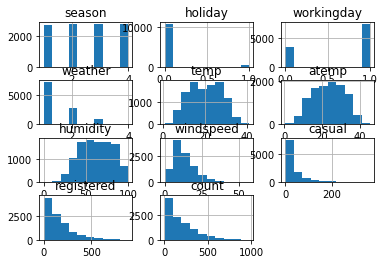

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [9]:
# create a new feature
train.loc[:, "datetime"] = pd.to_datetime(train.loc[:, "datetime"])
test.loc[:, "datetime"] = pd.to_datetime(test.loc[:, "datetime"])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [10]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [ ]:
# View are new feature
train.head()

datetime season  holiday  workingday  ...  year  month  day  hour
0 2011-01-01 00:00:00      1        0           0  ...  2011      1    1     0
1 2011-01-01 01:00:00      1        0           0  ...  2011      1    1     1
2 2011-01-01 02:00:00      1        0           0  ...  2011      1    1     2
3 2011-01-01 03:00:00      1        0           0  ...  2011      1    1     3
4 2011-01-01 04:00:00      1        0           0  ...  2011      1    1     4

[5 rows x 16 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efbe2442bd0>,
      dtype=object)

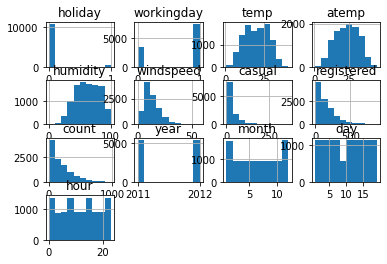

In [ ]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse"
    ).fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,
    presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220112_212155/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220112_212155/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 13
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11488.61 MB
	Train Data (Original)  Memory Usage: 0.98 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting Cat

[1000]	train_set's rmse: 30.8186	valid_set's rmse: 38.4291
[2000]	train_set's rmse: 25.4239	valid_set's rmse: 36.1393
[3000]	train_set's rmse: 22.5686	valid_set's rmse: 35.6903
[4000]	train_set's rmse: 20.5877	valid_set's rmse: 35.5711
[5000]	train_set's rmse: 19.0435	valid_set's rmse: 35.5486


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.3019	valid_set's rmse: 41.0917
[2000]	train_set's rmse: 25.4089	valid_set's rmse: 38.7923
[3000]	train_set's rmse: 22.682	valid_set's rmse: 38.0445
[4000]	train_set's rmse: 20.7477	valid_set's rmse: 37.6701
[5000]	train_set's rmse: 19.2301	valid_set's rmse: 37.5143
[6000]	train_set's rmse: 18.0161	valid_set's rmse: 37.3559
[7000]	train_set's rmse: 16.9715	valid_set's rmse: 37.2906
[8000]	train_set's rmse: 16.0611	valid_set's rmse: 37.2206
[9000]	train_set's rmse: 15.2683	valid_set's rmse: 37.1952
[10000]	train_set's rmse: 14.5678	valid_set's rmse: 37.1924


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.8968	valid_set's rmse: 35.5721
[2000]	train_set's rmse: 25.8631	valid_set's rmse: 34.288
[3000]	train_set's rmse: 23.0637	valid_set's rmse: 34.1613


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.1963	valid_set's rmse: 41.0073
[2000]	train_set's rmse: 25.1657	valid_set's rmse: 39.5208
[3000]	train_set's rmse: 22.4714	valid_set's rmse: 38.891
[4000]	train_set's rmse: 20.6602	valid_set's rmse: 38.6141
[5000]	train_set's rmse: 19.2024	valid_set's rmse: 38.3924
[6000]	train_set's rmse: 18.0244	valid_set's rmse: 38.232
[7000]	train_set's rmse: 16.9892	valid_set's rmse: 38.0679
[8000]	train_set's rmse: 16.0734	valid_set's rmse: 37.9926
[9000]	train_set's rmse: 15.292	valid_set's rmse: 37.9346
[10000]	train_set's rmse: 14.5874	valid_set's rmse: 37.8583


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.7161	valid_set's rmse: 38.2675
[2000]	train_set's rmse: 25.5034	valid_set's rmse: 36.7964
[3000]	train_set's rmse: 22.7183	valid_set's rmse: 36.6083


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.3783	valid_set's rmse: 42.1922
[2000]	train_set's rmse: 25.4027	valid_set's rmse: 40.825
[3000]	train_set's rmse: 22.6044	valid_set's rmse: 40.6565
[4000]	train_set's rmse: 20.6399	valid_set's rmse: 40.551


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.6785	valid_set's rmse: 38.6888
[2000]	train_set's rmse: 25.6628	valid_set's rmse: 35.913
[3000]	train_set's rmse: 22.8607	valid_set's rmse: 35.0407
[4000]	train_set's rmse: 20.8954	valid_set's rmse: 34.7444
[5000]	train_set's rmse: 19.3693	valid_set's rmse: 34.6106
[6000]	train_set's rmse: 18.0937	valid_set's rmse: 34.5086
[7000]	train_set's rmse: 17.0039	valid_set's rmse: 34.5219


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.7847	valid_set's rmse: 40.0936
[2000]	train_set's rmse: 25.4609	valid_set's rmse: 38.335
[3000]	train_set's rmse: 22.6799	valid_set's rmse: 37.7931
[4000]	train_set's rmse: 20.8023	valid_set's rmse: 37.6372
[5000]	train_set's rmse: 19.2946	valid_set's rmse: 37.4755
[6000]	train_set's rmse: 18.0187	valid_set's rmse: 37.3536
[7000]	train_set's rmse: 16.9566	valid_set's rmse: 37.3147
[8000]	train_set's rmse: 16.0353	valid_set's rmse: 37.2951
[9000]	train_set's rmse: 15.2295	valid_set's rmse: 37.2903
[10000]	train_set's rmse: 14.5042	valid_set's rmse: 37.3442


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.2598	valid_set's rmse: 40.7273
[2000]	train_set's rmse: 25.2682	valid_set's rmse: 39.8782
[3000]	train_set's rmse: 22.5407	valid_set's rmse: 39.8429


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 31.0398	valid_set's rmse: 37.6854
[2000]	train_set's rmse: 25.8317	valid_set's rmse: 35.4668
[3000]	train_set's rmse: 23.0887	valid_set's rmse: 34.8136
[4000]	train_set's rmse: 21.1229	valid_set's rmse: 34.5371
[5000]	train_set's rmse: 19.5767	valid_set's rmse: 34.3685
[6000]	train_set's rmse: 18.3516	valid_set's rmse: 34.2276
[7000]	train_set's rmse: 17.2755	valid_set's rmse: 34.2726


	-36.8251	 = Validation score   (root_mean_squared_error)
	95.28s	 = Training   runtime
	5.1s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 286.77s of the 486.71s of remaining time.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.1363	valid_set's rmse: 35.556
[2000]	train_set's rmse: 15.5229	valid_set's rmse: 35.4489


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.0431	valid_set's rmse: 36.9388
[2000]	train_set's rmse: 15.5393	valid_set's rmse: 36.1223
[3000]	train_set's rmse: 12.2068	valid_set's rmse: 35.9677
[4000]	train_set's rmse: 9.97753	valid_set's rmse: 35.9639


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.4253	valid_set's rmse: 33.0295


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.4591	valid_set's rmse: 38.0987
[2000]	train_set's rmse: 15.6967	valid_set's rmse: 37.1129
[3000]	train_set's rmse: 12.2044	valid_set's rmse: 36.7212
[4000]	train_set's rmse: 9.95476	valid_set's rmse: 36.6786


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.43	valid_set's rmse: 37.371
[2000]	train_set's rmse: 15.5136	valid_set's rmse: 36.986


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.6619	valid_set's rmse: 35.9541


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.0051	valid_set's rmse: 35.6024
[2000]	train_set's rmse: 15.4015	valid_set's rmse: 34.9824


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.3287	valid_set's rmse: 36.3245
[2000]	train_set's rmse: 15.6834	valid_set's rmse: 35.8282
[3000]	train_set's rmse: 12.2992	valid_set's rmse: 35.5694
[4000]	train_set's rmse: 10.1773	valid_set's rmse: 35.5318


	-36.5863	 = Validation score   (root_mean_squared_error)
	36.08s	 = Training   runtime
	1.63s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 244.94s of the 444.88s of remaining time.
	-41.3243	 = Validation score   (root_mean_squared_error)
	10.98s	 = Training   runtime
	0.49s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 232.66s of the 432.6s of remaining time.
	Time limit exceeded... Skipping CatBoost_BAG_L1.
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 204.02s of the 403.96s of remaining time.
	-41.0311	 = Validation score   (root_mean_squared_error)
	4.46s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 198.23s of the 398.17s of remaining time.
	-45.4168	 = Validation score   (root_mean_squared_error)
	149.29s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ... Training model for up 

In [ ]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.029454      10.155910  490.824291                0.000745           0.431925            3       True         17
1      WeightedEnsemble_L2  -35.159474       8.021527  326.907185                0.000749           0.483585            2       True          9
2          CatBoost_BAG_L2  -35.341252       8.986034  366.211876                0.077499          35.262077            2       True         13
3          LightGBM_BAG_L2  -35.546448       9.051810  339.401589                0.143275           8.451790            2       True         11
4     ExtraTreesMSE_BAG_L2  -35.561368       9.477804  338.935531                0.569269           7.985732            2       True         14
5   NeuralNetFastAI_BAG_L2  -35.824764       9.365122  438.692769         

{'leaderboard':                      model   score_val  ...  can_infer  fit_order
 0      WeightedEnsemble_L3  -35.029454  ...       True         17
 1      WeightedEnsemble_L2  -35.159474  ...       True          9
 2          CatBoost_BAG_L2  -35.341252  ...       True         13
 3          LightGBM_BAG_L2  -35.546448  ...       True         11
 4     ExtraTreesMSE_BAG_L2  -35.561368  ...       True         14
 5   NeuralNetFastAI_BAG_L2  -35.824764  ...       True         15
 6        LightGBMXT_BAG_L2  -36.039664  ...       True         10
 7   RandomForestMSE_BAG_L2  -36.254113  ...       True         12
 8          LightGBM_BAG_L1  -36.586278  ...       True          4
 9        LightGBMXT_BAG_L1  -36.825093  ...       True          3
 10          XGBoost_BAG_L1  -37.425499  ...       True          8
 11          XGBoost_BAG_L2  -38.165297  ...       True         16
 12    ExtraTreesMSE_BAG_L1  -41.031078  ...       True          6
 13  RandomForestMSE_BAG_L1  -41.324329  ...   

In [ ]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features = {'datetime': test['datetime'], 'Pred_count': predictions_new_features}
predictions_new_features = pd.DataFrame(data=predictions_new_features)
predictions_new_features.head()

datetime  Pred_count
0 2011-01-20 00:00:00   12.691998
1 2011-01-20 01:00:00    4.707187
2 2011-01-20 02:00:00    3.468102
3 2011-01-20 03:00:00    3.434032
4 2011-01-20 04:00:00    3.928625

In [ ]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features['Pred_count']<0] = 0

In [ ]:
predictions_new_features.describe()

Pred_count
count  6493.000000
mean    190.081589
std     172.848434
min       1.221206
25%      46.991890
50%     147.572662
75%     283.675110
max     870.337036

In [ ]:
# Same submitting predictions
submission_new_features = pd.read_csv('/content/submission.csv')
submission_new_features["count"] = predictions_new_features['Pred_count']
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:03<00:00, 56.3kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2022-01-12 21:40:38  new features          complete  0.47165      0.47165       
submission.csv               2022-01-12 20:46:44  first raw submission  complete  1.39920      1.39920       


#### New Score of `0.47165`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [1]:
import autogluon.core as ag
## From autogluon documentation
nn_options = {  
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability 
}

gbm_options = {  
    'num_boost_round': 100,  # number of boosting rounds 
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options, 
                  }  

num_trials = 3  # try at most 3 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse"
    ).fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,
    presets='best_quality', hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

ModuleNotFoundError: No module named 'autogluon'

In [ ]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3 -41.282342       5.709038  576.037574                0.000790           0.277052            3       True         10
1        LightGBM_BAG_L2/T0 -41.307625       3.033459  384.648088                0.130620           4.754860            2       True          6
2        LightGBM_BAG_L1/T2 -42.384438       0.139868    4.150900                0.139868           4.150900            1       True          3
3       WeightedEnsemble_L2 -42.384438       0.140630    4.430936                0.000763           0.280037            2       True          5
4        LightGBM_BAG_L1/T0 -42.790304       0.152393    4.254586                0.152393           4.254586            1       True          1
5        LightGBM_BAG_L2/T2 -43.965599       3.033939  384.676854         

{'leaderboard':                       model  score_val  ...  can_infer  fit_order
 0       WeightedEnsemble_L3 -41.282342  ...       True         10
 1        LightGBM_BAG_L2/T0 -41.307625  ...       True          6
 2        LightGBM_BAG_L1/T2 -42.384438  ...       True          3
 3       WeightedEnsemble_L2 -42.384438  ...       True          5
 4        LightGBM_BAG_L1/T0 -42.790304  ...       True          1
 5        LightGBM_BAG_L2/T2 -43.965599  ...       True          8
 6        LightGBM_BAG_L2/T1 -44.192568  ...       True          7
 7        LightGBM_BAG_L1/T1 -55.501303  ...       True          2
 8  NeuralNetMXNet_BAG_L2/T0 -56.404482  ...       True          9
 9  NeuralNetMXNet_BAG_L1/T0 -83.645148  ...       True          4
 
 [10 rows x 9 columns],
 'max_stack_level': 3,
 'model_best': 'WeightedEnsemble_L3',
 'model_fit_times': {'LightGBM_BAG_L1/T0': 4.25458550453186,
  'LightGBM_BAG_L1/T1': 4.189963340759277,
  'LightGBM_BAG_L1/T2': 4.150899648666382,
  'LightGBM_BA

In [ ]:
prediction_new_hpo = predictor_new_hpo.predict(test)
prediction_new_hpo = {'datetime': test['datetime'], 'Pred_count': prediction_new_hpo}
prediction_new_hpo = pd.DataFrame(data=prediction_new_hpo)
prediction_new_hpo.head()

datetime  Pred_count
0 2011-01-20 00:00:00   12.144185
1 2011-01-20 01:00:00    8.368087
2 2011-01-20 02:00:00    8.332276
3 2011-01-20 03:00:00    8.282018
4 2011-01-20 04:00:00    8.296806

In [ ]:
# Remember to set all negative values to zero
prediction_new_hpo[prediction_new_hpo['Pred_count']<0] = 0

In [ ]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('/content/submission.csv')
submission_new_hpo["count"] = prediction_new_hpo['Pred_count']
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:03<00:00, 51.0kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-01-12 23:27:06  new features with hyperparameters  complete  0.50893      0.50893       
submission_new_features.csv  2022-01-12 21:40:38  new features                       complete  0.47165      0.47165       
submission.csv               2022-01-12 20:46:44  first raw submission               complete  1.39920      1.39920       


#### New Score of `.50893`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

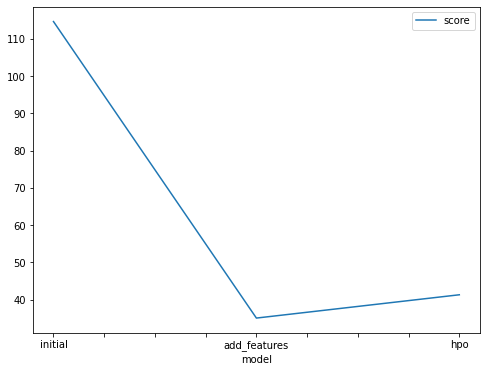

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [114.633955,  35.029454, 41.282342]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

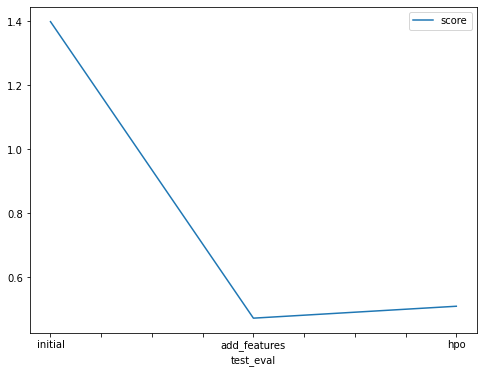

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.39920,  0.47165, 0.50893]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [10]:
# The 3 hyperparameters we tuned with the kaggle score as the result
hyperparams_df = pd.DataFrame({
    "model": ["initial_model", "add_features_model", "hpo_model"],
    "hpo1": ['default_vals', 'default_vals', 'GBM: num_leaves: lower=26, upper=66'],
    "hpo2": ['default_vals', 'default_vals', 'NN: dropout_prob: 0.0, 0.5'],
    "hpo3": ['default_vals', 'default_vals', 'GBM: num_boost_round: 100'],
    "score": [1.39920,  0.47165, 0.50893]
})

In [11]:
hyperparams_df.head()

model                                 hpo1  \
0       initial_model                         default_vals   
1  add_features_model                         default_vals   
2           hpo_model  GBM: num_leaves: lower=26, upper=66   

                         hpo2                       hpo3    score  
0                default_vals               default_vals  1.39920  
1                default_vals               default_vals  0.47165  
2  NN: dropout_prob: 0.0, 0.5  GBM: num_boost_round: 100  0.50893

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [ ]:
sub_new = pd.read_csv('/content/submission_new_features.csv')

Plot time series of train and test data

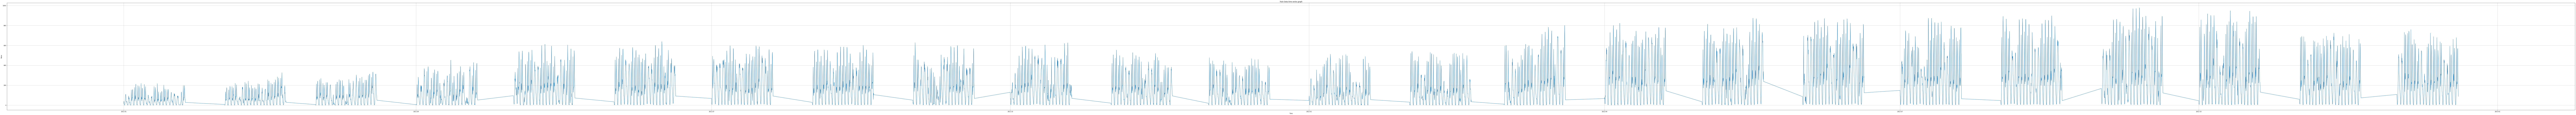

In [ ]:
import matplotlib.pyplot as plt
series = train["count"].to_numpy()
time = train["datetime"].to_numpy()


plt.figure(figsize=(350, 15))
plot_series(time, series)
plt.title("Train Data time series graph")
#plot_series(time1, series1)
plt.show()

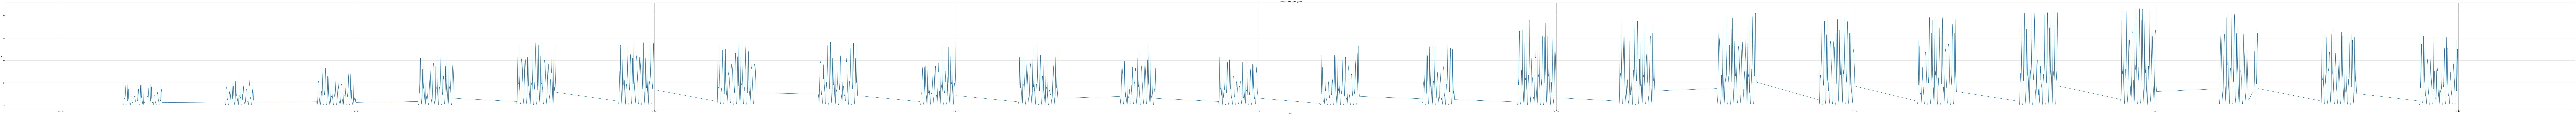

In [ ]:
sub_new.loc[:, "datetime"] = pd.to_datetime(sub_new.loc[:, "datetime"])

series1 = sub_new["count"].to_numpy()
time1 = sub_new["datetime"].to_numpy()

plt.figure(figsize=(350, 15))
#plot_series(time, series)
plot_series(time1, series1)
plt.title("Test Data time series graph")
plt.show()

Prediction with XGBoost

In [12]:
import xgboost as xgb

In [31]:
train_df = pd.read_csv('/content/train.csv')

In [33]:
test_df = pd.read_csv('/content/test.csv')

In [34]:
train_df.loc[:, "datetime"] = pd.to_datetime(train_df.loc[:, "datetime"])
test_df.loc[:, "datetime"] = pd.to_datetime(test_df.loc[:, "datetime"])

train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour

test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['day'] = test_df['datetime'].dt.day
test_df['hour'] = test_df['datetime'].dt.hour

In [39]:
trainxgb = train_df.drop(['casual', 'registered','count', 'datetime'], axis=1)
trainxgb.head()

season  holiday  workingday  weather  ...  year  month  day  hour
0       1        0           0        1  ...  2011      1    1     0
1       1        0           0        1  ...  2011      1    1     1
2       1        0           0        1  ...  2011      1    1     2
3       1        0           0        1  ...  2011      1    1     3
4       1        0           0        1  ...  2011      1    1     4

[5 rows x 12 columns]

In [36]:
countxgb = train_df['count']
countxgb.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [42]:
train_xgb = xgb.DMatrix(
    trainxgb, countxgb
)

params = {"objective": "reg:linear"} #"objective":"reg:linear"
bst = xgb.train(params, train_xgb)

bst.predict(train_xgb)

[21:17:55] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


array([ 35.479843,  31.946043,  25.44875 , ..., 185.26509 , 141.68748 ,
       111.29078 ], dtype=float32)

In [12]:
!jupyter nbconvert --to html bike_sharing.ipynb

[NbConvertApp] Converting notebook bike_sharing.ipynb to html
C:\Users\pjher\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 6033735 bytes to bike_sharing.html
